In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

img_H = 0
img_W = 0
img_D = 0

#Reshare csv array to image
def data_reshape(x,y,shape=48,depth=1):
  x = np.array(x)
  x = x.reshape(len(x),shape,shape,depth)
  y = np.array(y)
  return x, y

#Load FAFFE
def load_FAFEE():
  x_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/JAFFE/x_val.csv",header=None)
  y_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/JAFFE/y_val.csv",header=None)
  x_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/JAFFE/x_train.csv",header=None)
  y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/JAFFE/y_train.csv",header=None)

  x = [x_train,x_val]
  y = [y_train,y_val]
  x = pd.concat(x)
  y = pd.concat(y)

  x, y = data_reshape(x, y, 256)
  x, y = shuffle(x, y,random_state = 2021)
  
  img_H = x.shape[1]
  img_W = x.shape[2]
  img_D = x.shape[3]
  print (x.shape,y.shape)
  return x, y


#Load already prepared CK+
def load_CKplus_full():
  x = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/inputs.csv",header=None)
  y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/labels.csv",header=None)
  
  x, y = data_reshape(x, y)

  img_H = x.shape[1]
  img_W = x.shape[2]
  img_D = x.shape[3]
  return x, y

def load_CKplus_split():
  x = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/inputs.csv",header=None)
  y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/labels.csv",header=None)
  x, y = shuffle(x, y,random_state = 2021)

  x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=147, random_state=2021)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=147, random_state=2021)

  x_train, y_train = data_reshape(x_train, y_train)
  x_val, y_val = data_reshape(x_val, y_val)
  x_test, y_test = data_reshape(x_test, y_test)

  img_H = x_train.shape[1]
  img_W = x_train.shape[2]
  img_D = x_train.shape[3]
  print(x_train.shape,y_train.shape)
  return x_train, y_train, x_test, y_test, x_val, y_val

#Load already prepared FER2013
def load_FER2013():
  x_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/x_train.csv",header=None,)
  y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/y_train.csv",header=None)
  x_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/x_test.csv",header=None)
  y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/y_test.csv",header=None)
  x_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/x_val.csv",header=None)
  y_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/y_val.csv",header=None)

  x_train, y_train = data_reshape(x_train, y_train)
  x_val, y_val = data_reshape(x_val, y_val)
  x_test, y_test = data_reshape(x_test, y_test)

  img_H = x_train.shape[1]
  img_W = x_train.shape[2]
  img_D = x_train.shape[3]
  print(x_train.shape,y_train.shape)
  return x_train, y_train, x_test, y_test, x_val, y_val


x, y = load_FAFEE()


(213, 256, 256, 1) (213, 1)


In [3]:
#face recognition packages
!pip install opencv-python
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 15 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=28d884796f3fdc85dabd62818b37bae77c92c54fb4461319715c930b1023f845
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [35]:
#face detection, crop, sharpen, emboss using both face_recognition and cv2 packages
import face_recognition
from skimage.feature import local_binary_pattern
import cv2
import math
from google.colab.patches import cv2_imshow
from PIL import Image, ImageEnhance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def transform(img):
  if len(img.shape)>2:
    img = img.reshape(64,64)
  #gamma
  mid = 0.5 
  mean = np.mean(img)
  gamma = math.log(mid*255)/math.log(mean)
  img = np.power(img, gamma).clip(0,255).astype(np.uint8)

  #img = Image.fromarray(img)
  #filter = ImageEnhance.Contrast(img)# add contrast
  #img = filter.enhance(2)

  #img = img.filter(ImageEnhance.ImageFilter.SMOOTH)
  #img = img.filter(ImageEnhance.ImageFilter.EMBOSS)#emboss
  #img = img.filter(ImageEnhance.ImageFilter.EDGE_ENHANCE)
  
  #img = local_binary_pattern(img, 30, 1)
  #img = np.array(img)
  return img
def pre_process(input, target, output_height=64, output_width=64):
  face_cascade_name = cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml'
  face_cascade = cv2.CascadeClassifier()
  if not face_cascade.load(cv2.samples.findFile(face_cascade_name)):
    print("Error loading xml file")
    exit(0)

  x_temp = []
  y_temp = []
  #plt.figure(figsize=[8,8])
  for i in range(len(input)):
    img = np.array(input[i],'uint8')
    face_detect_1 = face_recognition.face_locations(img) #Using face_recoginition
    face_detect_2 = face_cascade.detectMultiScale(img,1.1, 1) #Using cv2

    if (len(face_detect_2)>0):
      (x, y, w, h) = face_detect_2[0]
      img = img[y:y + h, x:x + w]
      img = cv2.resize(img, (output_height, output_width))
      
      img = transform(img)
      img = img.reshape(output_height,output_width,1)
      x_temp.append(img)
      y_temp.append(target[i])

    elif (len(face_detect_1)>0):
      (y, w, h, x) = face_detect_1[0]
      img = img[y:y + h, x:x + w]
      img = cv2.resize(img,(output_height, output_width))
      
      img = transform(img)
      img = img.reshape(output_height,output_width,1)
      x_temp.append(img)
      y_temp.append(target[i])

    #cv2.rectangle(img, (x, y), (x+w, y+h), (0,0,0), 1)
    #print(i, x, y, w, h)

  x_temp = np.array(x_temp)
  y_temp = np.array(y_temp)
  return x_temp, y_temp

x, y = pre_process(x, y)

#For conveniency when training
trainx = x.copy()
trainy = y.copy()

x.shape, y.shape

((213, 64, 64, 1), (213, 1))

Display 50 images from the train set in the form of 5x5 matrix with their respective labels:


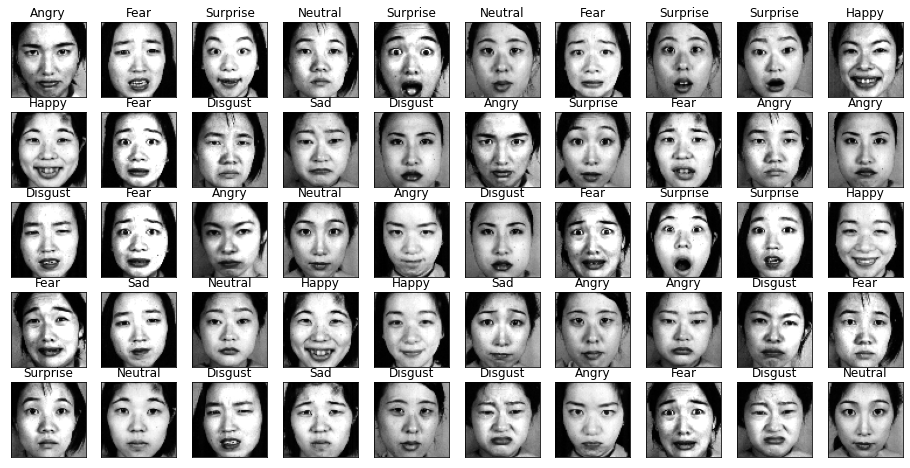

In [36]:
import matplotlib.pyplot as plt
# Displaying 25 images from training dataset in 5x5 matrix
emotion={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'} #for FER2013
#emotion = {0:'anger',1:'contempt',2:'disgust',3:'fear',4:'happy',5:'sadness',6:'surprise'} #for CK+
def plot_image(input_images,labels):
  print("Display 50 images from the train set in the form of 5x5 matrix with their respective labels:")
  plt.figure(figsize=[16,8])
  for i in range(50):
    plt.subplot(5,10,1+i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(input_images[i].reshape([64,64]), cmap='gray')
    plt.title(emotion[int(labels[i])])
  plt.show()

plot_image(x,y)



Epoch 1/200
14/14 [==============================] - 10s 191ms/step - loss: 2.3302 - accuracy: 0.1361 - val_loss: 2.3100 - val_accuracy: 0.1364
Epoch 2/200
14/14 [==============================] - 1s 60ms/step - loss: 2.0728 - accuracy: 0.2251 - val_loss: 2.3202 - val_accuracy: 0.1364
Epoch 3/200
14/14 [==============================] - 1s 62ms/step - loss: 2.0285 - accuracy: 0.2304 - val_loss: 2.4068 - val_accuracy: 0.0909
Epoch 4/200
14/14 [==============================] - 1s 64ms/step - loss: 1.9555 - accuracy: 0.2880 - val_loss: 2.6627 - val_accuracy: 0.1364
Epoch 5/200
14/14 [==============================] - 1s 61ms/step - loss: 1.8745 - accuracy: 0.3089 - val_loss: 2.3493 - val_accuracy: 0.0909
Epoch 6/200
14/14 [==============================] - 1s 56ms/step - loss: 1.7622 - accuracy: 0.3717 - val_loss: 2.4237 - val_accuracy: 0.2273
Epoch 7/200
14/14 [==============================] - 1s 58ms/step - loss: 1.5372 - accuracy: 0.5026 - val_loss: 4.9614 - val_accuracy: 0.1818
Epoc

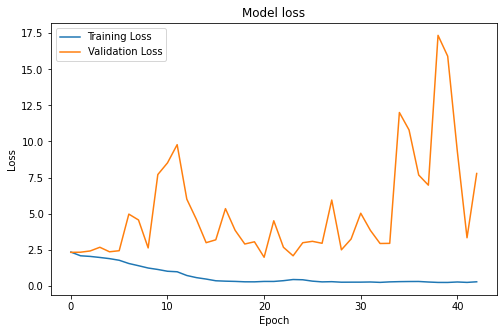

Plot the accuracy (Train and Validation)


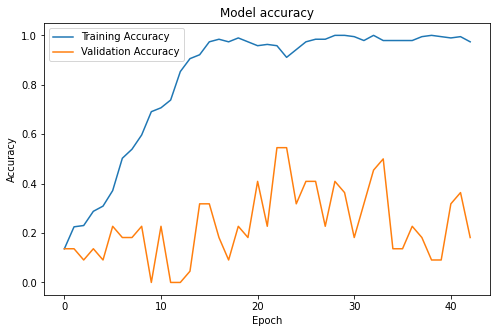

In [48]:
#CBAM 

from __future__ import print_function
import keras
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import resnet_v1, mobilenets
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from one_cycle_lr import OneCycleLr


# Training parameters
batch_size = 14
epochs = 200
data_augmentation = True
num_classes = 7

attention_module = 'cbam_block'
base_model = 'ResNet18'
# Choose what attention_module to use: cbam_block / se_block / None
model_type = base_model if attention_module==None else base_model+' '+attention_module


# Load dataset.
x = trainx.copy()
y = trainy.copy()

x, x_val, y, y_val = train_test_split(x, y,test_size=0.1, random_state=2021)

# Input image dimensions.
input_shape = x.shape[1:]

# Normalize data.
x = x.astype('float32') / 255
x_val = x_val.astype('float32') / 255

# Convert class vectors to binary class matrices.
y = to_categorical(y, num_classes)
y_val = to_categorical(y_val, num_classes)


# This will preprocessing data augmentation:
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)
datagen.fit(x)

for imgs, labels in datagen.flow(x, y,batch_size = len(x_train), seed=2021):
  x_train = imgs
  y_train = labels
  break

depth = 20 # For ResNet, specify the depth (e.g. ResNet50: depth=50, ResNet101: Depth=101)
model = resnet_v1.resnet_v1(input_shape=input_shape, depth=depth,num_classes=7, attention_module='cbam_block')
#model = mobilenets.MobileNet(input_shape=input_shape, classes=num_classes, attention_module='cbam_block')
#model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer= Adam(),#SGD(momentum=0.9, clipvalue=0.1), #SGD(decay=2e-5, momentum=0.9, nesterov=True),
              metrics=['accuracy'])
#model.summary()

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'model.{epoch:03d}.h5' + model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)
# 1 cycle learning rate
one_c = OneCycleLr(max_lr=0.1, steps_per_epoch=len(x_train), epochs=epochs)

#Early stopping
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, one_c, early_stop]

history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=callbacks)

def plot_model_history(history):
  # Plot training loss values
  print("Plot loss values (Train vs. Validation)")
  plt.figure(figsize=(8, 5))
  plt.plot(history.history['loss'],label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

  print("Plot the accuracy (Train and Validation)")
  plt.figure(figsize=(8, 5))
  plt.plot(history.history['accuracy'],label='Training Accuracy')
  plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

plot_model_history(history)
# Score trained model.
#scores = model.evaluate(x_test, y_test, verbose=1,batch_size=batch_size,)